# Reading ADV Data with MHKiT

The following example demonstrates a simple workflow for analyzing Acoustic Doppler Velocimetry (ADV) data using MHKiT. MHKiT has brought the DOLfYN codebase in as an MHKiT module for working with ADV and Acoustic Doppler Current Profiler (ADCP) data.
   
A typical ADV data workflow is broken down into
  1. Review the raw data
      - Check timestamps
      - Look at velocity data quality, particularly for spiking
  2. Check for spurious datapoints and remove. Replace bad datapoints using interpolation if desired
  3. Rotate the data into principal flow coordinates (streamwise, cross-stream, vertical)
  4. Average the data into bins, or ensembles, of a set time length (normally 5 to 10 min)
  5. Calculate turbulence statistics (turbulence intensity, TKE, Reynolds stresses) of the measured flowfield

Start by importing the necessary tools:

In [12]:
from mhkit import dolfyn
from mhkit.dolfyn.adv import api

## Read Raw Instrument Data

DOLfYN currently only carries support for the Nortek Vector ADV. The example loaded here is a short clip of data from a test deployment to show DOLfN's capabilities.

Start by reading in the raw datafile downloaded from the instrument. The `dolfyn.read` function reads the raw file and dumps the information into an xarray Dataset, which contains three groups of variables:

1. Velocity, amplitude, and correlation of the Doppler velocimetry
2. Measurements of the instrument's bearing and environment
3. Orientation matrices DOLfYN uses for rotating through coordinate frames.

In [13]:
ds = dolfyn.read('data/dolfyn/vector_data01.VEC')

Reading file data/dolfyn/vector_data01.VEC ...
 end of file at 3000000 bytes.


There are two ways to see what's in a Dataset. The first is to simply type the dataset's name to see the standard xarray output. To access a particular variable in a dataset, use dict-style (`ds['vel']`) or attribute-style syntax (`ds.vel`). See the [xarray docs](http://xarray.pydata.org/en/stable/getting-started-guide/quick-overview.html) for more details on how to use the xarray format.

In [14]:
# print the dataset
ds

<xarray.Dataset>
Dimensions:              (time: 122912, beam: 3, dir: 3, x: 3, x*: 3, earth: 3, inst: 3)
Coordinates:
  * time                 (time) datetime64[ns] 2012-06-12T12:00:02.968749 ......
  * beam                 (beam) int32 1 2 3
  * dir                  (dir) <U1 'X' 'Y' 'Z'
  * x                    (x) int32 1 2 3
  * x*                   (x*) int32 1 2 3
  * earth                (earth) <U1 'E' 'N' 'U'
  * inst                 (inst) <U1 'X' 'Y' 'Z'
Data variables: (12/15)
    beam2inst_orientmat  (x, x*) float64 2.709 -1.34 -1.364 ... -0.3438 -0.3499
    batt                 (time) float32 13.2 13.2 13.2 13.2 ... nan nan nan nan
    c_sound              (time) float32 1.493e+03 1.493e+03 ... nan nan
    heading              (time) float32 5.6 10.5 10.51 10.52 ... nan nan nan nan
    pitch                (time) float32 -31.5 -31.7 -31.69 ... nan nan nan
    roll                 (time) float32 0.4 4.2 4.253 4.306 ... nan nan nan nan
    ...                   ...
    vel                  (dir, time) float32 -1.002 -1.008 -0.944 ... nan nan
    amp                  (beam, time) uint8 104 110 111 113 108 ... 0 0 0 0 0
    corr                 (beam, time) uint8 97 91 97 98 90 95 95 ... 0 0 0 0 0 0
    orientation_down     (time) bool True True True True ... True True True True
    pressure             (time) float64 5.448 5.436 5.484 5.448 ... 0.0 0.0 0.0
    orientmat            (earth, inst, time) float32 0.0832 0.155 ... -0.7065
Attributes: (12/39)
    inst_make:                   Nortek
    inst_model:                  Vector
    inst_type:                   ADV
    rotate_vars:                 ['vel']
    n_beams:                     3
    profile_mode:                continuous
    ...                          ...
    recorder_size_bytes:         4074766336
    vel_range:                   normal
    firmware_version:            3.34
    fs:                          32.0
    coord_sys:                   inst
    has_imu:                     0

A second way provided to look at data is through the *DOLfYN view*. This view has several convenience methods, shortcuts, and functions built-in. It includes an alternate – and somewhat more informative/compact – description of the data object when in interactive mode. This can be accessed using

In [15]:
ds_dolfyn = ds.velds
ds_dolfyn

<ADV data object>:  Nortek Vector
  . 1.07 hours (started: Jun 12, 2012 12:00)
  . inst-frame
  . (122912 pings @ 32.0Hz)
  Variables:
  - time ('time',)
  - vel ('dir', 'time')
  - orientmat ('earth', 'inst', 'time')
  - heading ('time',)
  - pitch ('time',)
  - roll ('time',)
  - temp ('time',)
  - pressure ('time',)
  - amp ('beam', 'time')
  - corr ('beam', 'time')
  ... and others (see `<obj>.variables`)

## QC'ing Data

ADV velocity data tends to have spikes due to Doppler noise, and the common way to "despike" the data is by using the phase-space algorithm by Goring and Nikora (2002). DOLfYN integrates this function using a 2-step approach: create a logical mask where True corresponds to a spike detection, and then utilize an interpolation function to replace the spikes.

In [16]:
# Clean the file using the Goring+Nikora method:
mask = api.clean.GN2002(ds.vel, npt=5000)
# Replace bad datapoints via cubic spline interpolation
ds['vel'] = api.clean.clean_fill(ds['vel'], mask, npt=12, method='cubic', maxgap=None)

print('Percent of data containing spikes: {0:.2f}%'.format(100*mask.mean()))

# If interpolation isn't desired:
ds_nan = ds.copy(deep=True)
ds_nan.coords['mask'] = (('dir','time'), ~mask)
ds_nan['vel'] = ds_nan['vel'].where(ds_nan['mask'])

Percent of data containing spikes: 0.73%


## Coordinate Rotations

Now that the data has been cleaned, the next step is to rotate the velocity data into true East, North, Up (ENU) coordinates.

ADVs use an internal compass or magnetometer to determine magnetic ENU directions. The `set_declination` function takes the user supplied magnetic declination (which can be looked up online for specific coordinates) and adjusts the orientation matrix saved within the dataset.

Instruments save vector data in the coordinate system specified in the deployment configuration file. To make the data useful, it must be rotated through coordinate systems ("beam"<->"inst"<->"earth"<->"principal"), done through the `rotate2` function. If the "earth" (ENU) coordinate system is specified, DOLfYN will automatically rotate the dataset through the necessary coordinate systems to get there. The `inplace` set as true will alter the input dataset "in place", a.k.a. it not create a new dataset.

In [17]:
# First set the magnetic declination
dolfyn.set_declination(ds, declin=10, inplace=True) # declination points 10 degrees East

# Rotate that data from the instrument to earth frame (ENU):
dolfyn.rotate2(ds, 'earth', inplace=True)

Once in the true ENU frame of reference, we can calculate the principal flow direction for the velocity data and rotate it into the principal frame of reference (streamwise, cross-stream, vertical). Principal flow directions are aligned with and orthogonal to the flow streamlines at the measurement location. 

First, the principal flow direction must be calculated through `calc_principal_heading`. As a standard for DOLfYN functions, those that begin with "calc_*" require the velocity data for input. This function is different from others in DOLfYN in that it requires place the output in an attribute called "principal_heading", as shown below.

Again we use `rotate2` to change coordinate systems.

In [18]:
ds.attrs['principal_heading'] = dolfyn.calc_principal_heading(ds['vel'])
dolfyn.rotate2(ds, 'principal', inplace=True)

## Averaging Data
The next step in ADV analysis is to average the velocity data into time bins (ensembles) and calculate turbulence statistics. There are a couple ways to do this, and both of these methods use the same variable inputs and return identical datasets.

1. Define an averaging object, create a binned dataset and calculate basic turbulence statistics. This is done by initiating an object from the `ADVBinner` class, and subsequently supplying that object with our dataset.

2. Alternatively, the functional version of ADVBinner, `turbulence_statistics`.

Function inputs shown here are the dataset itself; "n_bin", the number of elements in each bin; "fs", the ADV's sampling frequency in Hz; "n_fft", optional, the number of elements per FFT for spectral analysis; "freq_units", optional, either in Hz or rad/s, of the calculated spectral frequency vector.

All of the variables in the returned dataset have been bin-averaged, where each average is computed using the number of elements specified in "n_bins". Additional variables in this dataset include the turbulent kinetic energy (TKE) vector ("ds_binned.tke_vec"), the Reynold's stresses ("ds_binned.stress"), and the power spectral densities ("ds_binned.psd"), calculated for each bin.

In [19]:
binner = api.ADVBinner(n_bin=9600, fs=ds.fs, n_fft=2048)
ds_binned = binner(ds, freq_units="Hz")

ds_binned = api.turbulence_statistics(ds, n_bin=9600, fs=ds.fs, n_fft=2048, freq_units="Hz")

The benefit to using `ADVBinner` is that one has access to all of the velocity and turbulence analysis functions that DOLfYN contains. If basic analysis will suffice, the `turbulence_statistics` function is the most convienent. Either option can still utilize DOLfYN's shortcuts.

See the [DOLfYN API](https://dolfyn.readthedocs.io/en/latest/apidoc/dolfyn.binners.html) for the full list of functions and shortcuts. A few examples are shown below.

Some things to know:
- All functions operate bin-by-bin.
- Some functions will fail if there are NaN's in the data stream (Notably the PSD functions)
- "Shorcuts", as referred to in DOLfYN, are functions accessible by the xarray accessor `velds`, as shown below. The list of "shorcuts" available through `velds` are listed [here](https://dolfyn.readthedocs.io/en/latest/apidoc/dolfyn.shortcuts.html). Some shorcut variables require the raw dataset, some an averaged dataset.

For instance, 
- `bin_variance` calculates the binned-variance of each variable in the raw dataset, the complementary to `bin_average`. Variables returned by this function contain a "_var" suffix to their name.
- `cross_spectral_density` calculates the cross spectral power density between each direction of the supplied DataArray. Note that inputs specified in creating the `ADVBinner` object can be overridden or additionally specified for a particular function call.
- `velds.I` is the shortcut for turbulence intensity. This particular shortcut requires a dataset created by `bin_average`, because it requires bin-averaged data to calculate.


In [20]:
# Calculate the variance of each variable in the dataset and add to the averaged dataset
ds_binned = binner.bin_variance(ds, out_ds=ds_binned) 

# Calculate the cross power spectral density
ds_binned['csd'] = binner.cross_spectral_density(ds['vel'], freq_units='Hz', n_fft_coh=2048)

# Calculated the turbulence intensity (requires a binned dataset)
ds_binned['TI'] = ds_binned.velds.I

Plotting can be taken care of through matplotlib. As an example, the mean spectrum in the streamwise direction is plotted here. This spectrum shows the mean energy density in the flow at a particular flow frequency.

Text(0.5, 1.0, 'Streamwise Direction')

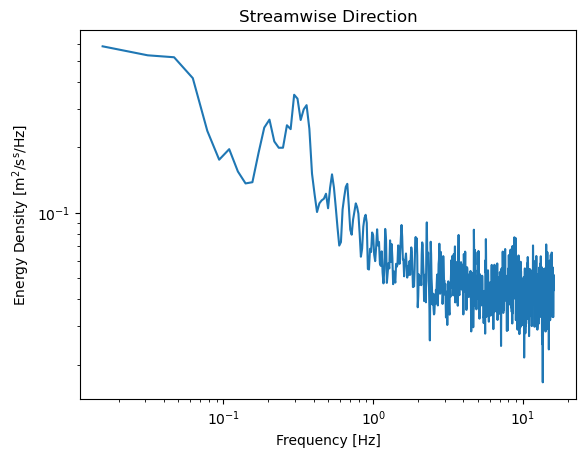

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.loglog(ds_binned['freq'], ds_binned['psd'].sel(S='Sxx').mean(dim='time'))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Energy Density $\mathrm{[m^2/s^s/Hz]}$')
plt.title('Streamwise Direction')

## Saving and Loading DOLfYN datasets
Datasets can be saved and reloaded using the `save` and `load` functions. Xarray is saved natively in netCDF format, hence the ".nc" extension.

Note: DOLfYN datasets cannot be saved using xarray's native `ds.to_netcdf`; however, DOLfYN datasets can be opened using `xarray.open_dataset`.

In [22]:
# Uncomment these lines to save and load to your current working directory
#dolfyn.save(ds, 'your_data.nc')
#ds_saved = dolfyn.load('your_data.nc')